# Tutorial 06: Canonical Correlation Analysis

If we have two vectors $X = (X_1, \ldots, X_N)$ and $Y = (Y_1, \ldots, Y_N)$ of random variables, and there are correlations among the variables, then canonical correlation analysis (CCA) will find linear combinations of $X_i$ and $Y_i$ that have maximum correlation with each other. A typical use for CCA in an experimental context, is to take two sets of variables and see what is common amongst the two sets. For example, inn this tutorial we will learn how to use CCA to find correlations between biomedical images $X$ and patient metadata $Y$ (e.g. age). We will also learn how to visualize and interpret the results.

For more infomation regarding CCA, including its mathematical derivation, I highly recommend reading the [Wikipedia article](https://en.wikipedia.org/wiki/Canonical_correlation) on canonical correlation, as well as Magnus Borga's very comprehensive (and readable) [tutorial](https://www.cs.cmu.edu/~tom/10701_sp11/slides/CCA_tutorial.pdf) on CCA.

## Import Packages

As always, we need to import some useful packages. We will use the numerical Python package *Numpy* for array manipulation and *matplotlib* for plotting figures. Similarly to our tutorial on penalized linear discriminant analysis (PLDA), we are going to use the PCA class in *scikit-learn* (*sklearn*) to help reduce the dimension of our data before applying CCA. Also, we need to use *sklearn*'s `train_test_split()` function in order to split our data into training and testing sets. Moreover, if we want to use the *optimaltransport* package later, we must also add the package code to the current Python path (you can skip this step if the *optimaltransport* package has been installed via the pip package manager).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Add the optrans package to the Python path
# (change the path below to the location of the optimaltransport directory on your computer)
# Note: this step is not necessary if you have installed optimaltransport through pip.
import sys
sys.path.append('../../optimaltransport')

## Loading Data

Before we begin, let's first load some sample data. The data in this tutorial are from the [Open Access Series of Imaging Studies](http://www.oasis-brains.org/) (OASIS). OASIS is a project aimed at making neuroimaging data sets of the brain freely available to the scientific community. There are three datasets in total, but in these examples, we will use OASIS-1 -- cross-sectional MRI data in young, middle-aged, non-demented and demented older adults. The dataset comprises 416 subjects, aged 18 to 96. The subjects are all right-handed and include both men and women. Furthermore, 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease. In addition to the MRI scans, demographic, clinical, and derived anatomic measures are also provided in the OASIS dataset. These can be summarized as follows:

**Demographics**
* Gender
* Age
* Education level (Educ)
* Socioeconomic status (SES)

**Clinical**
* Mini-Mental State Examination (MMSE)
* Clinical Dementia Rating (CDR)

**Derived anatomic volumes**
* Estimated total intracranial volume (eTIV)
* Normalized whole brain volume (nWBV)
* Atlas scaling factor (ASF)

To make analyzing the MRIs more straightforward, the nice people from the OASIS project have provided pre-processed images, as well as the original MR scans. Moreover, I selected a single 2D axial slice from each pre-processed 3D brain scan, which should help speed up the computations in this tutorial. Nevertheless, CCA could be performed on 3D data. 

In [19]:
from optrans.datasets import oasis

# Load the image data, class labels, and metadata
fpath = '../optrans/datasets/oasis_data.npz'
img, label, metadata = oasis.load_data(fpath=fpath)

# Find incomplete metadata and remove those subjects
ind = ~np.isnan(metadata).any(axis=1)
img = img[ind]
label = label[ind]
metadata = metadata[ind]

## Peforming CCA on Non-Image Data

Ultimately, we want to be able to visualize correlations between patient metadata (e.g. age, neuropsychological test scores) and the MRI data. However, let's start with something simpler, and consider correlations between the non-image data. For example, perhaps we wish to find correlations between demographic/clinical data and derived anatomic volumes:

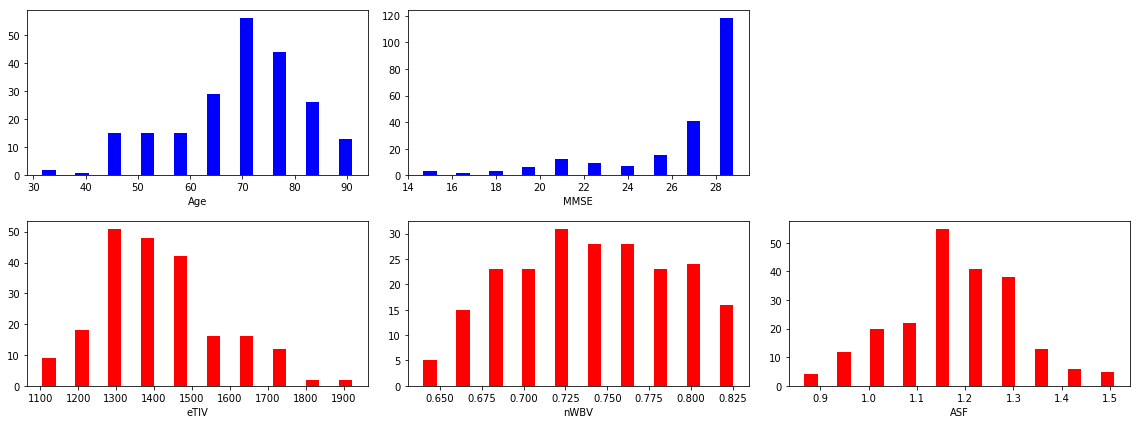

In [20]:
# Select some metadata
# Demographics/clinical data: X = (age, mmse)
# Derived anatomical measure: Y = (etiv, nwbv, asf)
X = metadata[:,[1,4]]
Y = metadata[:,6:9]

_, ax = plt.subplots(2, 3, figsize=(16,6))

# Plot histograms of X data (demographics/clinical)
for x,a,lab in zip(X.T,ax[0],['Age','MMSE']):
    hist, bins = np.histogram(x)
    width = (bins[1]-bins[0]) * 0.4
    a.bar(bins[:-1], hist, width=width, color='b')
    a.set_xlabel(lab)

# Plot histograms of Y data (derived anatomical measures)
for y,a,lab in zip(Y.T,ax[1],['eTIV','nWBV','ASF']):
    hist, bins = np.histogram(y)
    width = (bins[1]-bins[0]) * 0.4
    a.bar(bins[:-1], hist, width=width, color='r')
    a.set_xlabel(lab)

ax[0,2].axis('off')
plt.tight_layout()
plt.show()

Now that we have our $X$ data (blue) and $Y$ data (red) that we want to assess, we can perform CCA. Firstly, we have to import the `CCA` class from the `optrans.decomposition` module. We also have to split our data into train and test sets. To keep things simple, let's just split our data 50-50 for training and testing.

In [21]:
from optrans.decomposition import CCA

# Split into training and testing data
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=.5, random_state=42)

Our $X$ data only has 2 features, and our $Y$ data only has 3 features, so the maximum number of components that can be returned by the `CCA` class is 2 (i.e. `min(n_x_features,n_y_features)`. In many cases, you will probably only care about the most correlative direction between $X$ and $Y$, therefore, you only need to return a single component. This is the default setting for the `CCA` class, but we will explicitly set the number of components in the example below.

In [22]:
# Initialize CCA with 1 component
cca = CCA(n_components=1)

# Fit CCA and transform the training data
Xtr_cca, Ytr_cca = cca.fit_transform(Xtr, Ytr)

# Transform the testing data
Xte_cca, Yte_cca = cca.transform(Xte, Yte)

Similarly the the classifiers in the *scikit-learn* package, the `CCA` class has a `score()` function. For the `CCA` class, this function returns the Pearson product-moment correlation coefficient for each CCA component. The correlation coefficients is defined:

$$
\rho = \frac{\sum_i(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_i(x_i-\bar{x})^2}\sqrt{\sum_i(y_i-\bar{y})^2}}
$$

where $\bar{x}$ and $\bar{y}$ are the sample means:

$$
\bar{x} = \frac{1}{N} \sum_{i=1}^N x_i, \quad \bar{y} = \frac{1}{N} \sum_{i=1}^N y_i
$$

In [23]:
# Compute the correlation coefficient for the training and test data
corr_tr = cca.score(Xtr, Ytr)
corr_te = cca.score(Xte, Yte)

print('Corr. coefficient (train): {:.2f}'.format(corr_tr))
print('Corr. coefficient (test):  {:.2f}'.format(corr_te))

Corr. coefficient (train): 0.79
Corr. coefficient (test):  0.80


The direction learned by CCA on the training data seems the generalize well to our test data, since the correlation coefficients are very similar (0.79 vs. 0.80). In this example, we are only using a single split (also called a "fold") of training and testing data. In general, you should do many splits of the data to assess whether the correlation coefficient obtained on the training data is similar to the correlation coeffecient of the test data.

Since we have reduced our $X$ and $Y$ data to a single component, we can also plot the results on a scatter plot and visualize the correlation. Moreover, the *optrans.decomposition* module also has a useful function, `fit_line()`, that can be used to fit a 2D line to our transformed data. The `fit_line()` returns coordinates of two points on the line, which will allow us to plot the correlation of our data.

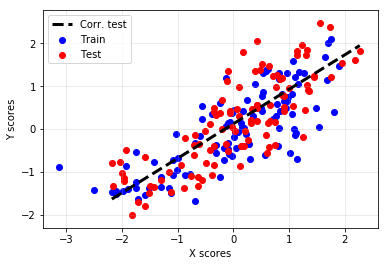

In [24]:
from optrans.decomposition import fit_line

# Get x-y coordinates of correlation line
xl, yl = fit_line(Xte_cca.squeeze(), Yte_cca.squeeze())

# Plot data projected on to first canonical direction
plt.scatter(Xtr_cca, Ytr_cca, c='b', label='Train')
plt.scatter(Xte_cca, Yte_cca, c='r', label='Test')
plt.plot(xl, yl, 'k--', lw=3, label='Corr. test')
plt.grid(alpha=.3)
plt.xlabel('X scores')
plt.ylabel('Y scores')
plt.legend()
plt.show()

## CCA Using Image Data

We can also use CCA to find correlations between images and non-image data. For example, using the same OASIS-1 dataset as before, we could find correlations between the axial MRI slices and subject age. If we can visualize the results, this might give us an insight into the changes that occur in the brain due to age. Therefore, let's repeat the example above, but using the image data as our vector $X$ and age as our vector $Y$. Identically to the `PCA` and `PLDA` classes that we met in previous tutorials, the `CCA` class expects 1D inputs. Therefore, we need to reshape our 2D images into 1D arrays. As before, we also need to split our data into training and testing sets.

In [27]:
# X data: images (reshaped into 1D arrays)
n_samples, h, w = img.shape
X = img.reshape((n_samples,h*w))

# Y data: age
Y = metadata[:,1]

# Split data into train and test sets
Xtr, Xte, Ytr, Yte = train_test_split(X, metadata[:,1], test_size=.5, random_state=42)

# Reshape the Y vectors into n-by-1 arrays
Ytr = Ytr.reshape(-1,1)
Yte = Yte.reshape(-1,1)

The original 2D images are 208${\times}$176px, and therefore, the corresponding 1D arrays have 208${\times}$176=36608 features. Given the enormity of this feature space, it is almost guaranteed that we will be able to find a projection of our image data that perfectly correlates with age. This is an example of overfitting, since the direction learned on the training data will probably not result in a high correlation between the transformed test data and age. As a result, we will apply PCA to our image data before performing CCA. In this example, I am arbitrarily going to reduce the dimension of our $X$ data from 36608 features to 10 features. This may still be too many (or too few!) features, but this is only an example! Also, it is worth noting that our $Y$ vector only has one feature (age), therefore there is no point in performing PCA on this data.

In [37]:
pca = PCA(n_components=10)
Xtr_pca = pca.fit_transform(Xtr)
Xte_pca = pca.transform(Xte)

print('Shape of original training data:  ', Xtr.shape)
print('Shape of training data after PCA: ', Xtr_pca.shape)

Shape of original training data:   (108, 36608)
Shape of training data after PCA:  (108, 10)


Now that we have reduced the dimension of our $X$ (image) data, we can perform CCA. Once again, we are only interested in the most correlated direction between the MR image and subject age, so `n_components=1`. Furthermore, since the $Y$ already comprises one feature (age), we won't bother to transform this data after we have learned the CCA directions.

In [29]:
# Initialize CCA to return a single component
cca = CCA(n_components=1)

# Fit CCA to training data
cca.fit(Xtr_pca, Ytr)

# Transform the train and test data (images only)
Xtr_cca = cca.transform(Xtr_pca)
Xte_cca = cca.transform(Xte_pca)

As before, we can compute the correlation coefficient between the image and age data using the `score()` function.

In [30]:
# Compute the correlation coefficient for the training and test data
corr_tr = cca.score(Xtr_pca, Ytr)
corr_te = cca.score(Xte_pca, Yte)

print('Corr. coefficient (train): {:.2f}'.format(corr_tr))
print('Corr. coefficient (test):  {:.2f}'.format(corr_te))

Corr. coefficient (train): 0.77
Corr. coefficient (test):  0.66


Also, we can visualize the transformed data on a scatter plot. Since we didn't transform the $Y$ vector, the $y$-axis of our plot shows the true age values, rather than "Y scores". Identically to our non-image analysis, I'm using the `fit_line()` function in the *optrans.decomposition* module to help plot the correlated direction through the test data.

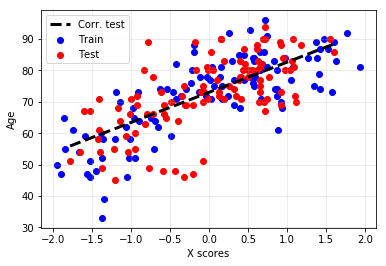

In [32]:
# Get x-y coordinates of correlation line
xl, yl = fit_line(Xte_cca.squeeze(), Yte.squeeze())

# Plot X data projected on to first canonical direction
plt.scatter(Xtr_cca, Ytr, c='b', label='Train')
plt.scatter(Xte_cca, Yte, c='r', label='Test')
plt.plot(xl, yl, 'k--', lw=3, label='Corr. test')
plt.grid(alpha=.3)
plt.xlabel('X scores')
plt.ylabel('Age')
plt.legend()
plt.show()

Since we're conducting CCA on image data, it would be useful if we could visualize the changes in the images that correspond to the correlative direction that we see in the figure above. Fortunately, we can use the `plot_mode_image()` function that we met in the PLDA tutorial to do this for us. This function is part of the *optrans.visualization* module, and allows us to reconstruct data from our data analysis pipeline (`[pca, cca]` in this case). For more information about the `plot_mode_image()` function, please see the *optimaltransport* package documentation.

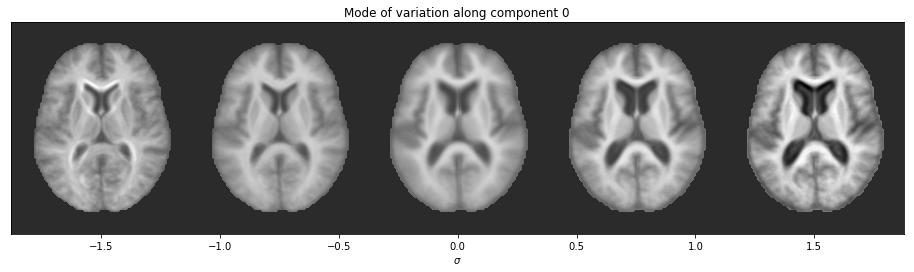

In [35]:
from optrans.visualization import plot_mode_image

plot_mode_image([pca,cca], shape=(h,w), n_std=3., n_steps=5, cmap='gray', figsize=(16,4))
plt.show()

The images above correspond to images along the $x$-axis of our scatter plot. On the left is a reconstructed image of the brain of a young person. On the right is a reconstructed brain of an elderly person. The changes that occur over time have been inferred by the canonical correlation analysis, and are consistent with the biology of aging brains. For example, it is expected that the ventricles get larger with age, and this is exactly what we are seeing in the figure above.